In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import os, time, gc, datetime
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
import lightgbm as lgb

In [2]:
def load_data():
    
    train_transaction = pd.read_csv("../data/train_transaction.csv") 
    train_identity = pd.read_csv("../data/train_identity.csv")  
    data=pd.merge(train_transaction,train_identity,how='left',on='TransactionID')
    
    return data

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
data = load_data()
data=reduce_mem_usage(data)

Mem. usage decreased to 650.48 Mb (66.8% reduction)


In [5]:
#Removing all V columns 

V_cols = [x for x in data.columns if x[0] == 'V']
data = data.drop(columns = V_cols, axis = 1)

print(data.shape)

(590540, 95)


In [6]:
#Removing all ID columns 

data = data.drop(columns = ['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10',
                 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21',
                 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
                 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38'], axis = 1)

print(data.shape)


(590540, 57)


In [7]:
# Handling missing value

from sklearn.impute import SimpleImputer

num_cols = pd.read_csv("../data/data_corr_mat.csv").columns.to_list()[1:]
cat_cols = [_ for _ in data.columns if _ not in num_cols]
num_cols=[_ for _ in data.columns if _ not in cat_cols]

print('imputation of missing values by most') ; st=time.time()
imp = SimpleImputer( strategy='most_frequent')
imp.fit(data[cat_cols])
data[cat_cols] = imp.transform(data[cat_cols])
    
print('imputation of missing values by mean') ; st=time.time()
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(data[num_cols])
data[num_cols] = imp.transform(data[num_cols])
print(time.time()-st,'s')

imputation of missing values by most
imputation of missing values by mean
2.470377206802368 s


In [8]:
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
data['Date'] = data['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
data['Date']

0        2017-12-02 00:00:00
1        2017-12-02 00:00:01
2        2017-12-02 00:01:09
3        2017-12-02 00:01:39
4        2017-12-02 00:01:46
                 ...        
590535   2018-06-01 23:57:27
590536   2018-06-01 23:57:29
590537   2018-06-01 23:57:59
590538   2018-06-01 23:58:08
590539   2018-06-01 23:58:51
Name: Date, Length: 590540, dtype: datetime64[ns]

In [9]:
#Label encoding

number = LabelEncoder()
for i in data.columns:
    if (data[i].dtype == 'object'):
        data[i] = number.fit_transform(data[i].astype('str'))
        data[i] = data[i].astype('object')

In [10]:
d1 = datetime.datetime(2018, 5, 1)
train_X = data[data['Date']<d1]
test_X = data[data['Date']>= d1]


y_train = train_X['isFraud'].copy()
conta = sum(y_train) / len(y_train)
X_train  = train_X.drop(columns = ['Date', 'isFraud'], axis = 1)

X_test1 = test_X.drop('Date', axis = 1)
X_test = test_X.drop(columns = ['Date', 'isFraud'], axis = 1)
y_test = X_test1['isFraud'].copy()

In [11]:
lgb_params =  {'num_leaves': 491,
         'min_child_weight': 0.03454472573214212,
         'feature_fraction': 0.3797454081646243,
         'bagging_fraction': 0.4181193142567742,
         'min_data_in_leaf': 106,
         'objective': 'binary',
         'max_depth': -1,
         'learning_rate': 0.006883242363721497,
         "boosting_type": "gbdt",
         "bagging_seed": 11,
         "metric": 'auc',
         'reg_alpha': 0.3899927210061127,
         'reg_lambda': 0.6485237330340494,
         'random_state': 47 }

In [12]:
correlated_features = set()
correlation_matrix = X_train.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [13]:
rfc = RandomForestClassifier(random_state=101)
rfecv = RFECV(lgb.LGBMClassifier(**lgb_params), step=10, scoring='roc_auc', cv=5, verbose=1)
rfecv.fit(X_train, y_train)

Fitting estimator with 56 features.
Fitting estimator with 46 features.
Fitting estimator with 36 features.
Fitting estimator with 26 features.
Fitting estimator with 16 features.
Fitting estimator with 6 features.
Fitting estimator with 56 features.
Fitting estimator with 46 features.
Fitting estimator with 36 features.
Fitting estimator with 26 features.
Fitting estimator with 16 features.
Fitting estimator with 6 features.
Fitting estimator with 56 features.
Fitting estimator with 46 features.
Fitting estimator with 36 features.
Fitting estimator with 26 features.
Fitting estimator with 16 features.
Fitting estimator with 6 features.
Fitting estimator with 56 features.
Fitting estimator with 46 features.
Fitting estimator with 36 features.
Fitting estimator with 26 features.
Fitting estimator with 16 features.
Fitting estimator with 6 features.
Fitting estimator with 56 features.
Fitting estimator with 46 features.
Fitting estimator with 36 features.
Fitting estimator with 26 featur

RFECV(cv=5,
      estimator=LGBMClassifier(bagging_fraction=0.4181193142567742,
                               bagging_seed=11, boosting_type='gbdt',
                               class_weight=None, colsample_bytree=1.0,
                               feature_fraction=0.3797454081646243,
                               importance_type='split',
                               learning_rate=0.006883242363721497, max_depth=-1,
                               metric='auc', min_child_samples=20,
                               min_child_weight=0.03454472573214212,
                               min_data_in_leaf=106, min_split_gain=0.0,
                               n_estimators=100, n_jobs=-1, num_leaves=491,
                               objective='binary', random_state=47,
                               reg_alpha=0.3899927210061127,
                               reg_lambda=0.6485237330340494, silent=True,
                               subsample=1.0, subsample_for_bin=200000,
            

In [14]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 56


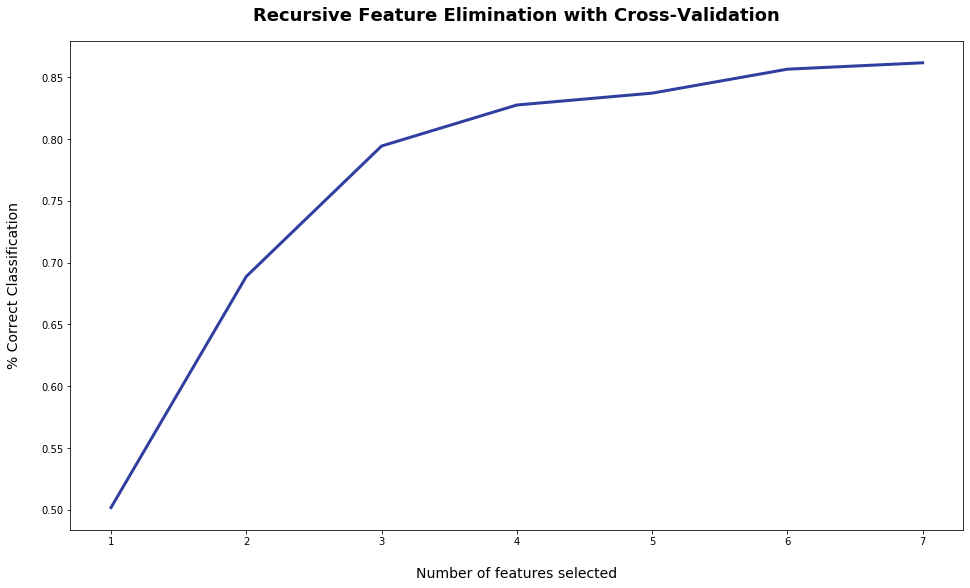

In [15]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [21]:
print(np.where(rfecv.support_ == False)[0])

X_train.drop(X_train.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

[]


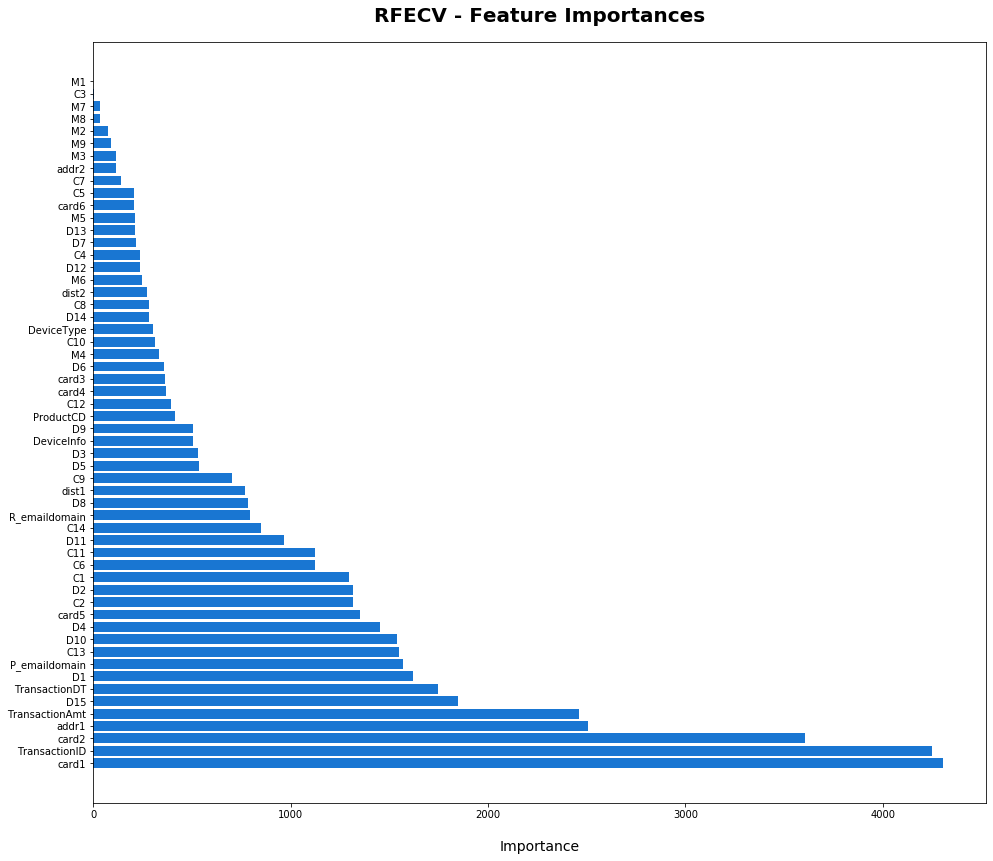

In [18]:
dset = pd.DataFrame()
dset['attr'] = X_train.columns
dset['importance'] = rfecv.estimator_.feature_importances_
dset = dset.sort_values(by='importance', ascending=False)

plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

In [19]:
#Recursive Feature Elimination selected 56 Optimal number of features

In [20]:
#Printing out all features with rank 1

for col in X_train.columns[rfecv.ranking_ == 1]:
    print(col) 

TransactionID
TransactionDT
TransactionAmt
ProductCD
card1
card2
card3
card4
card5
card6
addr1
addr2
dist1
dist2
P_emaildomain
R_emaildomain
C1
C2
C3
C4
C5
C6
C7
C8
C9
C10
C11
C12
C13
C14
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
M1
M2
M3
M4
M5
M6
M7
M8
M9
DeviceType
DeviceInfo
